In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error,log_loss
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version

from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

from matplotlib.pylab import rcParams
import xgboost as xgb

## Gradient boost

The main idea behind Gradient Boost is to create a strong predictive model using many "weak learners". Each "weak learner" is a predictive model that is not good on its own, but each successive "weak learner" learns through mistakes made by previous "weak learners". Each "weak learner" can be any type of a model, but the most common one people use are Decision Trees. So, we will focus solely on desicion trees as well.


General flow to Gradient Boost is as follows:

1. Create initial model $f_0$ whose guess is always the same for all data points.

2. For each data point in the training set $x^{(i)}$, calculate residual (error) $r^{(i)}$. (Though generally called pseudo-residual due to as scaling it a bit)

3. Build a "small" desision tree that tries to predict **errors** $r^{(i)}$ based on data points $x^{(i)}$.

4. Create the next model $f_1$, by adding scaled down version of a tree from part 3 to $f_0$. (This should remind you a bit of how gradient descent works. This is why this method is called Gradient Boost).

5. Repeat the process of finding new residuals, then building a new tree to predict them, and then adding scaled down version of that tree to $f_1$, and keep repeating this process until some stopping critiria is met.


This model can be used for regression and classification. Regression is a bit easier to understand, so we will start with that.

### Gradient Boost for Regression

First let's quickly go over the steps above to get the general flow, then we will add the math needed. Note though, the math will look a bit different form this general flow, but it will be actually the same.

1. To get initial model ($f_0$), we just take the average of targets as our prediction.

2. For each data point $x^{(i)}$ calculate the errors $r_1^{(i)}=y^{(i)}-f_0(x^{(i)})$ 

3. Build a tree model $T_1$ that predicts our residuals based on data points. We would usually limit how big the tree is to avoid overfit. We then modify each leaf to return a single value. If the leaf already have only one value, it will return that value, but if the leaf has more than one value, it will return the average of all values in that leaf.

4. We create a new model $f_1=f_0+\epsilon \cdot T_1$. The value $\epsilon$ is a learning rate. It scales down the tree which helps with avoiding overfitting again. The new model will have better prediction as we took a small step towards correct guesses.

5. We repeat the process, by getting new residuals $r_2$, building the tree model $T_2$ to guess new errors and then building a new model $f_2=f_1+\epsilon\cdot T_2$ and so on until we stop.


The usual stopping critiria is either reaching maximum number of trees (set as hyperparameter) and/or when the difference in residuals is too small. 

So after we stop, our final model is a sum of many weak models: $f_n=f_0+\epsilon\cdot T_1 + \epsilon\cdot T_2+ \dots \epsilon\cdot T_n$

Now, let's get to the math behind it:

We consider a loss function $L(x)=\frac{1}{2}(y-f(x))^2$, where $f(x)$ is some a prediction based on $x$. (this is just MSE divided by 2 for a single point). Note, I wrote this for a single point, MSE is basically the average of $L$ taking over all points.

1. Then we set our initial model to $f_0(x)=\mathop{\arg\min}_{\gamma} \sum_{i=1}^nL(y^{(i)}, \gamma)$. While this may look scary, it isn't that bad. All it says is that we are looking for a single value $\gamma$ for which our loss is minimized on the whole set. It is not hard to see that the $\gamma$ that gives us the minimum is just the average of all $y^{(i})$. 

2. Now we go through a loop creating residuals $r^{(i)}_{j}$ ($i$ goes through data points, $j$ is $j$-th iteration (or loop)). For simplicity of notation, I will skip $(i)$-th indecies and consider $r_j$ as collection of all residuals for all data points.

    Then the residuals are $$r_{j}=-\left.\frac{\partial L(y, f(x))}{\partial f(x)}\right|_{f(x)=f_{j-1}(x)}$$ This is just a residual (i.e. true minus predicted). We evaluated it by setting $f(x)=f_{j-1}(x)$. So, in the first loop is just $f_0$:

    $$r_1=y-f_0(x)=y-\gamma$$

    where $\gamma$ is the average of all $y$'s.

3. Now we build a tree $T_j$ to predict residuals. This tree will have some amount of leaves. Let's denote the set of all leaves in $j$-iteration by $I_j$ and each leaf in $I_j$ by $L_{jl}$). In each leaf $L_{jl}$ we calculate 'common' value:
   $$\gamma_{jl}=\mathop{\arg\min}_{\gamma} \sum_{x \in L_{jl}}L(y, f_{j-1}(x)+\gamma)$$

   This is similar to what we did to get $f_0(x)$, but this time we use "previous" guesses ($f_{j-1}(x)$) and we only go over values inside each leaf separatelly. But overall, it is still just the average of values in the leaf.

4. Now we create the new model. For given $x$,
   $$f_j(x)=f_{j-1}(x)+\epsilon \sum_{L_{ij}\in I_j}\gamma_{jl}I(x \in L_{jl})$$
   where $I(x \in L_{jl})=1$ if  $x\in L_{jl}$ and 0 otherwise. In other words, given $x$, $f_j(x)$ is the predicted value of old model plus the value from our tree $T_j$ scaled by some learning rate $\epsilon$.

### Example 1

First example is a simple application to a simple set.

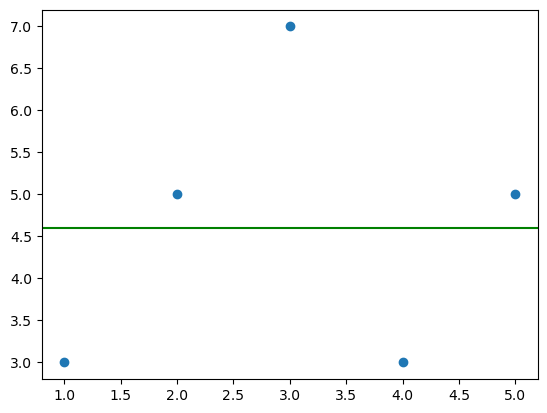

In [2]:
X=np.array([1,2,3,4,5]).reshape(-1,1)
y=np.array([3,5,7,3,5])
plt.scatter(X,y)
plt.axhline(y.mean(), color='green')

plt.show()

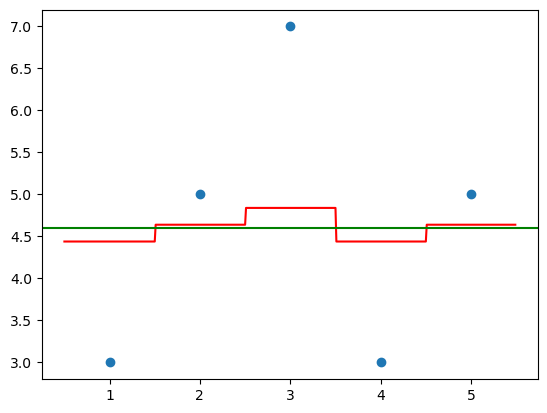

In [3]:
model1=GradientBoostingRegressor(n_estimators=1)
model1.fit(X,y)

xval=np.arange(0.5,5.5,0.01).reshape(-1,1)
pred=model1.predict(xval)
plt.scatter(X,y)
plt.plot(xval, pred, 'r')
plt.axhline(y.mean(), color='green')
plt.show()

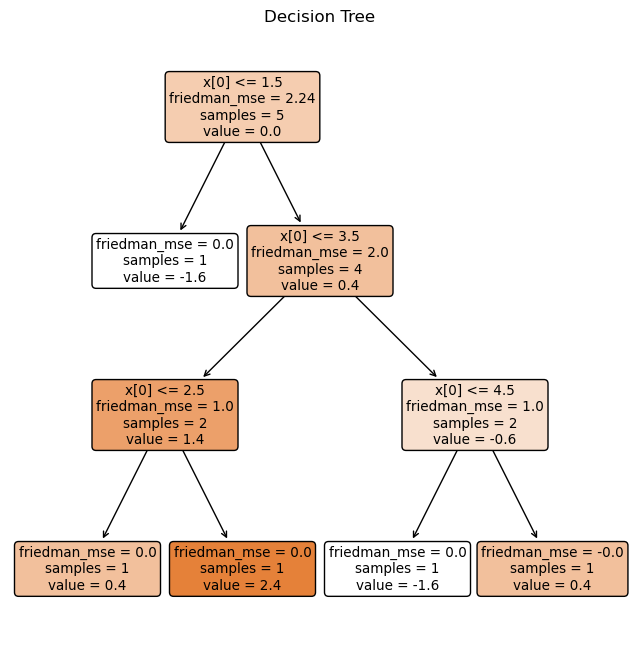

In [4]:
plt.figure(figsize=(8, 8))
plot_tree(model1.estimators_[0][0], filled=True, rounded=True)
plt.title("Decision Tree")
plt.show()

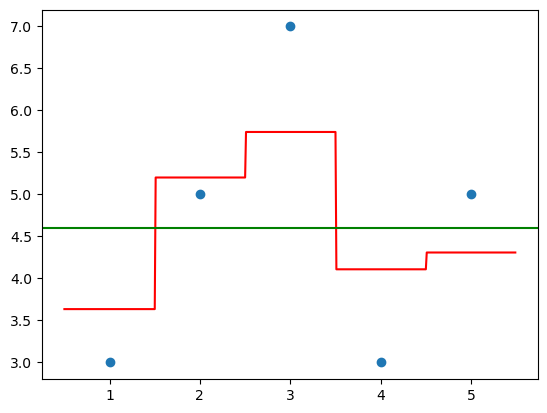

In [5]:
model2=GradientBoostingRegressor(max_depth =2, n_estimators=10)
model2.fit(X,y)

xval=np.arange(0.5,5.5,0.01).reshape(-1,1)
pred=model2.predict(xval)
plt.scatter(X,y)
plt.plot(xval, pred, 'r')
plt.axhline(y.mean(), color='green')
plt.show()

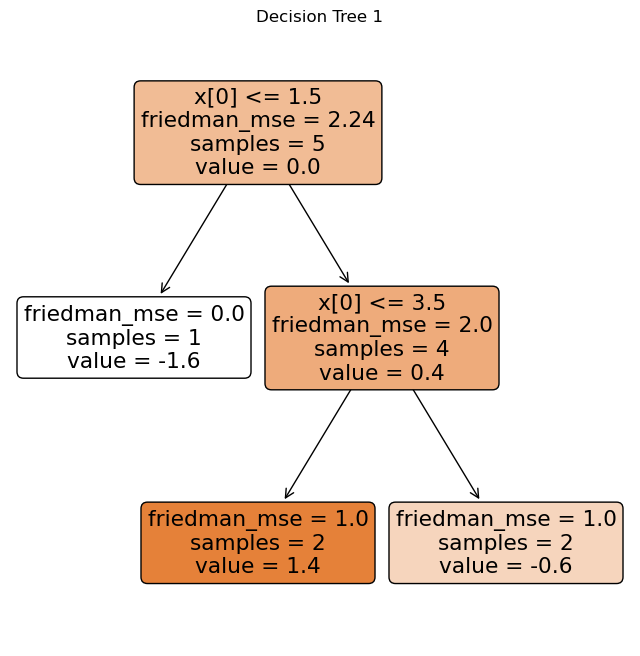

In [6]:
plt.figure(figsize=(8, 8))
plot_tree(model2.estimators_[0][0], filled=True, rounded=True)
plt.title("Decision Tree 1")
plt.show()

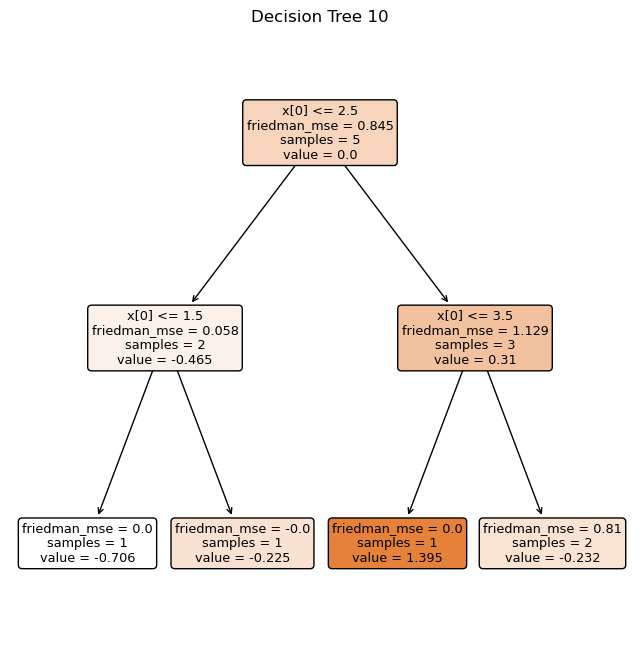

In [7]:
plt.figure(figsize=(8, 8))
plot_tree(model2.estimators_[9][0], filled=True, rounded=True)
plt.title("Decision Tree 10")
plt.show()

### Example 2

Let's generate a lot of points and apply Gradient boost regressor

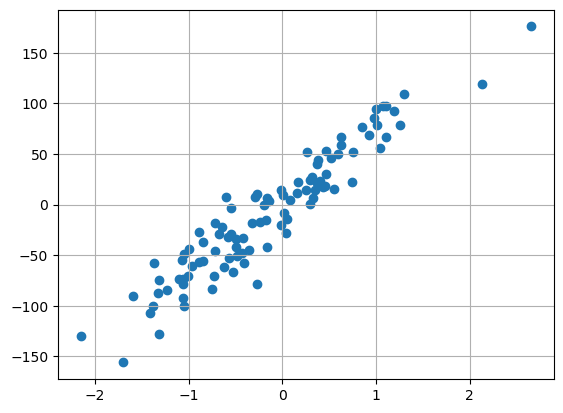

In [8]:
X, y = datasets.make_regression(n_samples=100, n_features=1, noise=20)
fig=plt.figure()
xv=np.linspace(0,5, 1000)
plt.grid()

plt.scatter(X,y) 
plt.show()

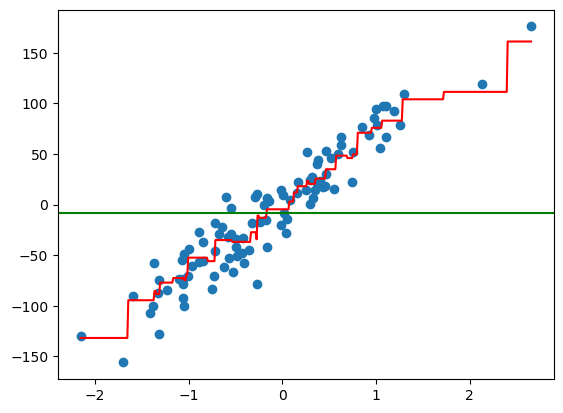

In [9]:
model3=GradientBoostingRegressor(max_depth=2, n_estimators=40)
model3.fit(X,y)

xval=np.arange(X.min(),X.max(),0.01).reshape(-1,1)
pred=model3.predict(xval)
plt.scatter(X,y)
plt.plot(xval, pred, 'r')
plt.axhline(y.mean(), color='green')
plt.show()

### Example 3

Big Dataset

In [11]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target
pd.DataFrame(X, columns=diabetes.feature_names)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [472]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [474]:
param_dist  = {
              'n_estimators': [30, 100, 200],
              'max_depth' : [2,3,4, 5],
              'learning_rate' :[0.01, 0.1]
             }

In [476]:
model=GradientBoostingRegressor()
tree_cv = GridSearchCV(model, param_dist, cv=5)

tree_cv.fit(X_train, y_train)
print("Tuned Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}
Best score is 0.4236994611401047


In [477]:
n_estimators=30

In [478]:
model4=GradientBoostingRegressor(max_depth=2, n_estimators=n_estimators, learning_rate=0.1)
model4.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=30)

In [482]:
pred=model4.predict(X_test) 
model4.train_score_
model4.score(X_test,y_test)

0.48663937462878337

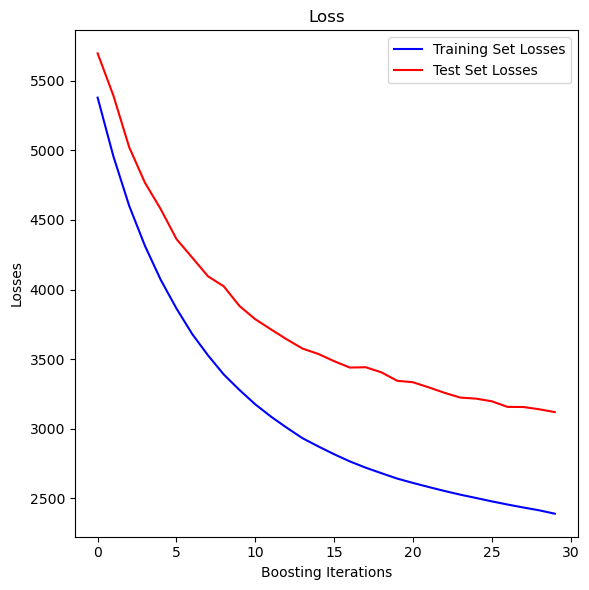

In [484]:
losses = np.zeros((n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(model4.staged_predict(X_test)):
    losses[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Loss")
plt.plot(
    np.arange(n_estimators),
    model4.train_score_,
    "b-",
    label="Training Set Losses",
)
plt.plot(
    np.arange(n_estimators), losses, "r-", label="Test Set Losses"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Losses")
fig.tight_layout()
plt.show()

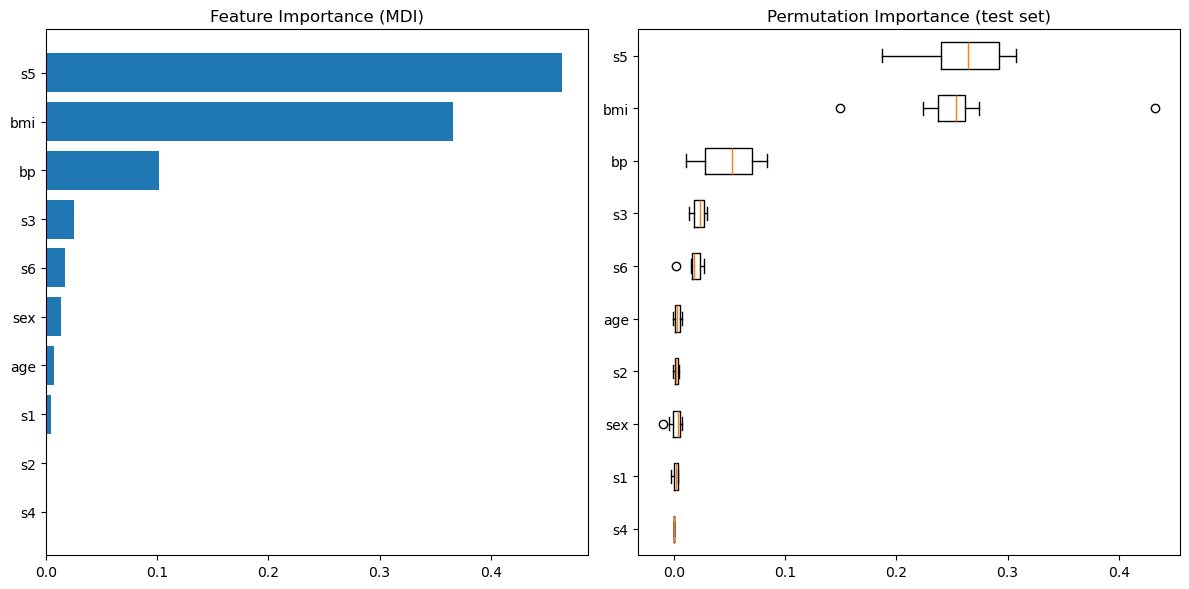

In [486]:
feature_importance = model4.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model4, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)

tick_labels_dict = {
    "labels": np.array(diabetes.feature_names)[sorted_idx]
}
plt.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Gradient Boost for Clasification

To deal with clasification we use similar ideas to logistic regression. We will look at the binary classification case first:

1. To make our values numerical we will use log of odds ($\ln(odds)=\ln(\frac{p}{1-p})$) followed by sigmoid to convert the values to probabilities, instead of the average. (Numerically, if we have 30 points in class 0 and 70 points in class 1, we would get $sigm(\ln(70/30))=sigm(0.847)=0.7$. Using normal threshold of 0.5, we basically classifying everyone to class 1 (i.e. majority class). What we are actually using here is negative log loss function as our loss function $L$:

$$L(y,p)=-(y\ln(p)+(1-y)\ln(1-p)=-\left(y\ln\left(\frac{p}{1-p}\right)-\ln(1-p)\right)=$$ $$=-\left(y\ln\left(\frac{p}{1-p}\right)+\ln\left(1+e^{\ln(p/(1-p)}\right)\right)=-(y\ln(odds)+\ln(1+e^{\ln(odds)})=-(y\cdot f+\ln(1+e^{f})=L(y, f),$$
where $f$ is our log of odds.
   
3. Then we compute residuals which equal to the difference between true values (0 or 1) and trained value (0.7 in the example from part 1). This comes, as in regression case, from taking derivative of our loss function and evaluating at previous predictions. 

4. We build the tree to guess residuals. However, we cant just add residuals to previous log-odds and we can't really compute log-odds with a single value for example. So, we use the following formula for each leaf:

$$Output=\frac{\sum \text{Residuals in the leaf}}{\sum (\text{Previous Prob})(1-\text{Previous Prob})}$$

Here the sums are taking over all values in the leaf. This formula comes from trying to minimize 
    
$$\gamma_{jl}=\mathop{\arg\min}_{\gamma} \sum_{x \in L_{jl}}L(y, f_{j-1}(x)+\gamma)$$

but instead of trying to find derivative right away (it's hard), we approximate it using degree 2 Taylor polynomial, and taking derivative of it:

$$L(y, f+\gamma) \approx L(y,f)+\frac{d}{df}L(y,f)\gamma + \frac{1}{2}\frac{d^2}{df^2}L(y,f)\gamma^2$$

$$\frac{d}{d\gamma}L(y, f+\gamma) \approx \frac{d}{df}L(y,f)+\frac{d^2}{df^2}L(y,f)\gamma$$

Making it equal to zero and solving for $\gamma$, we get

$$\gamma = \frac{-\frac{d}{df}L(y,f)}{\frac{d^2}{df^2}L(y,f)}$$

Here the numerator is equal to residual and the denominator is equal to $p(1-p)$.

4. Then we update predictions by taking previous log-odds (i.e 0.847 in above example) and adding new outputs scaled by some learning rate. Then we convert it to probability by taking sigmoid function. This is our new model.

5. Then we repeat the process just like in the regression case.

In [77]:
bcancer=datasets.load_breast_cancer()
X, y = bcancer.data, bcancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [78]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([0, 1]), array([164, 291], dtype=int64))

In [79]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)


In [80]:
param_dist  = {
              'n_estimators': [30, 100, 200, 300],
              'max_depth' : [2,3,4, 5],
              'learning_rate' :[0.01, 0.1]
             }

In [68]:
model=GradientBoostingClassifier()
cv = GridSearchCV(model, param_dist, cv=5)

cv.fit(X_train, y_train, sample_weight=sample_weights)
print("Tuned Parameters: {}".format(cv.best_params_))
print("Best score is {}".format(cv.best_score_))

Tuned Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}
Best score is 0.9626373626373625


In [81]:
classmodel=GradientBoostingClassifier(learning_rate= 0.1, max_depth= 2, n_estimators= 300)
classmodel.fit(X_train, y_train,sample_weight=sample_weights)

GradientBoostingClassifier(max_depth=2, n_estimators=300)

In [82]:
print("Test score =",classmodel.score(X_test,y_test))

Test score = 0.9210526315789473


In [83]:
confusion_matrix(y_test,classmodel.predict(X_test))

array([[45,  3],
       [ 6, 60]], dtype=int64)

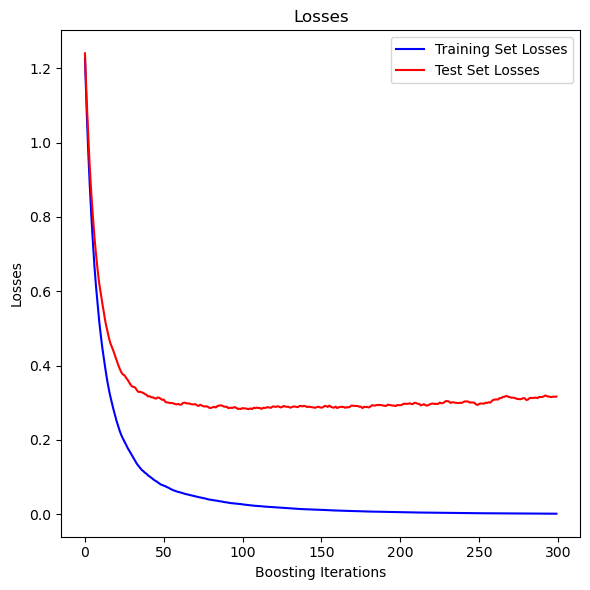

In [84]:

n_estimators=300
losses = np.zeros((n_estimators,), dtype=np.float64)
for i, y_proba in enumerate(classmodel.staged_predict_proba(X_test)):
        losses[i] = 2 * log_loss(y_test, y_proba[:,1])

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Losses")
plt.plot(
    np.arange(n_estimators),
    classmodel.train_score_,
    "b-",
    label="Training Set Losses",
)
plt.plot(
    np.arange(n_estimators), losses, "r-", label="Test Set Losses"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Losses")
fig.tight_layout()
plt.show()

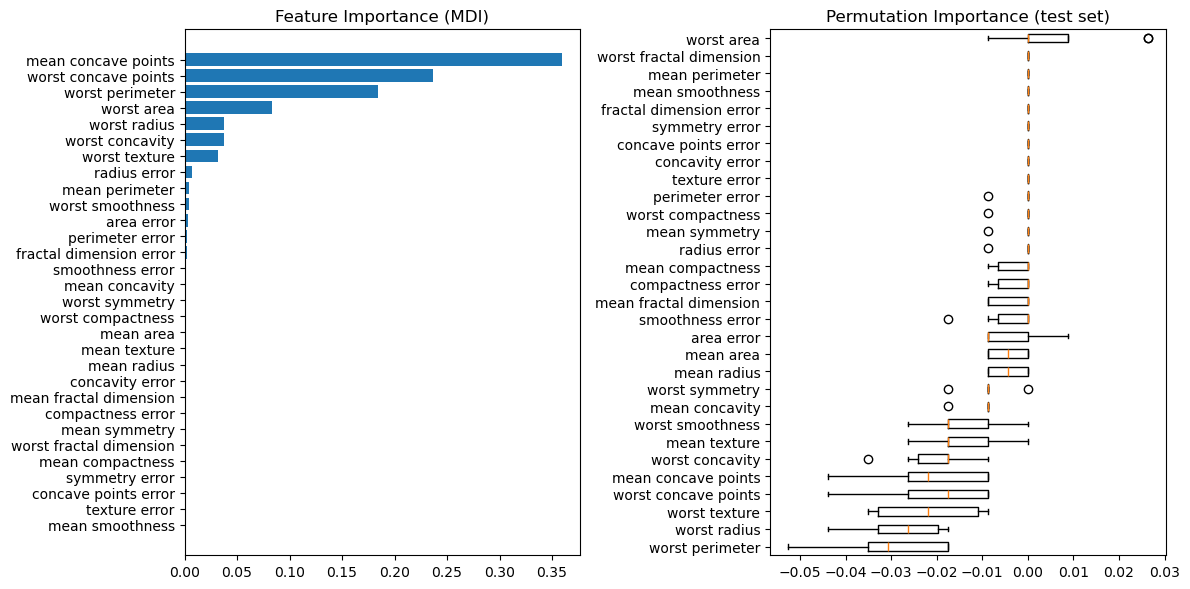

In [85]:
feature_importance = classmodel.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(bcancer.feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    classmodel, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)

tick_labels_dict = {
    "labels": np.array(bcancer.feature_names)[sorted_idx]
}
plt.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Multiclass classification

If we have $c$ classes, we one-hot encode the true labels, and consider $c$ binary models for each class (a point belongs to a specific class or not). So we would use log-odds and sigmoid to get pseudo-residuals in each "class-model". We view them as a vector in $\mathbb{R}^c$. Then, after sigmoid, we apply softmax to this vector to get actual classification probability vector that we compare to one-hot encoded true label to get actual residual. Then we will build $c$ trees predicting corresponding residuals and continue looking at it as if it is binary classification to get output values and update log-odds for corresponding location. We then can calculate cross-entropy loss to see the actual loss of the whole model. We repeat this process as many steps as needed.

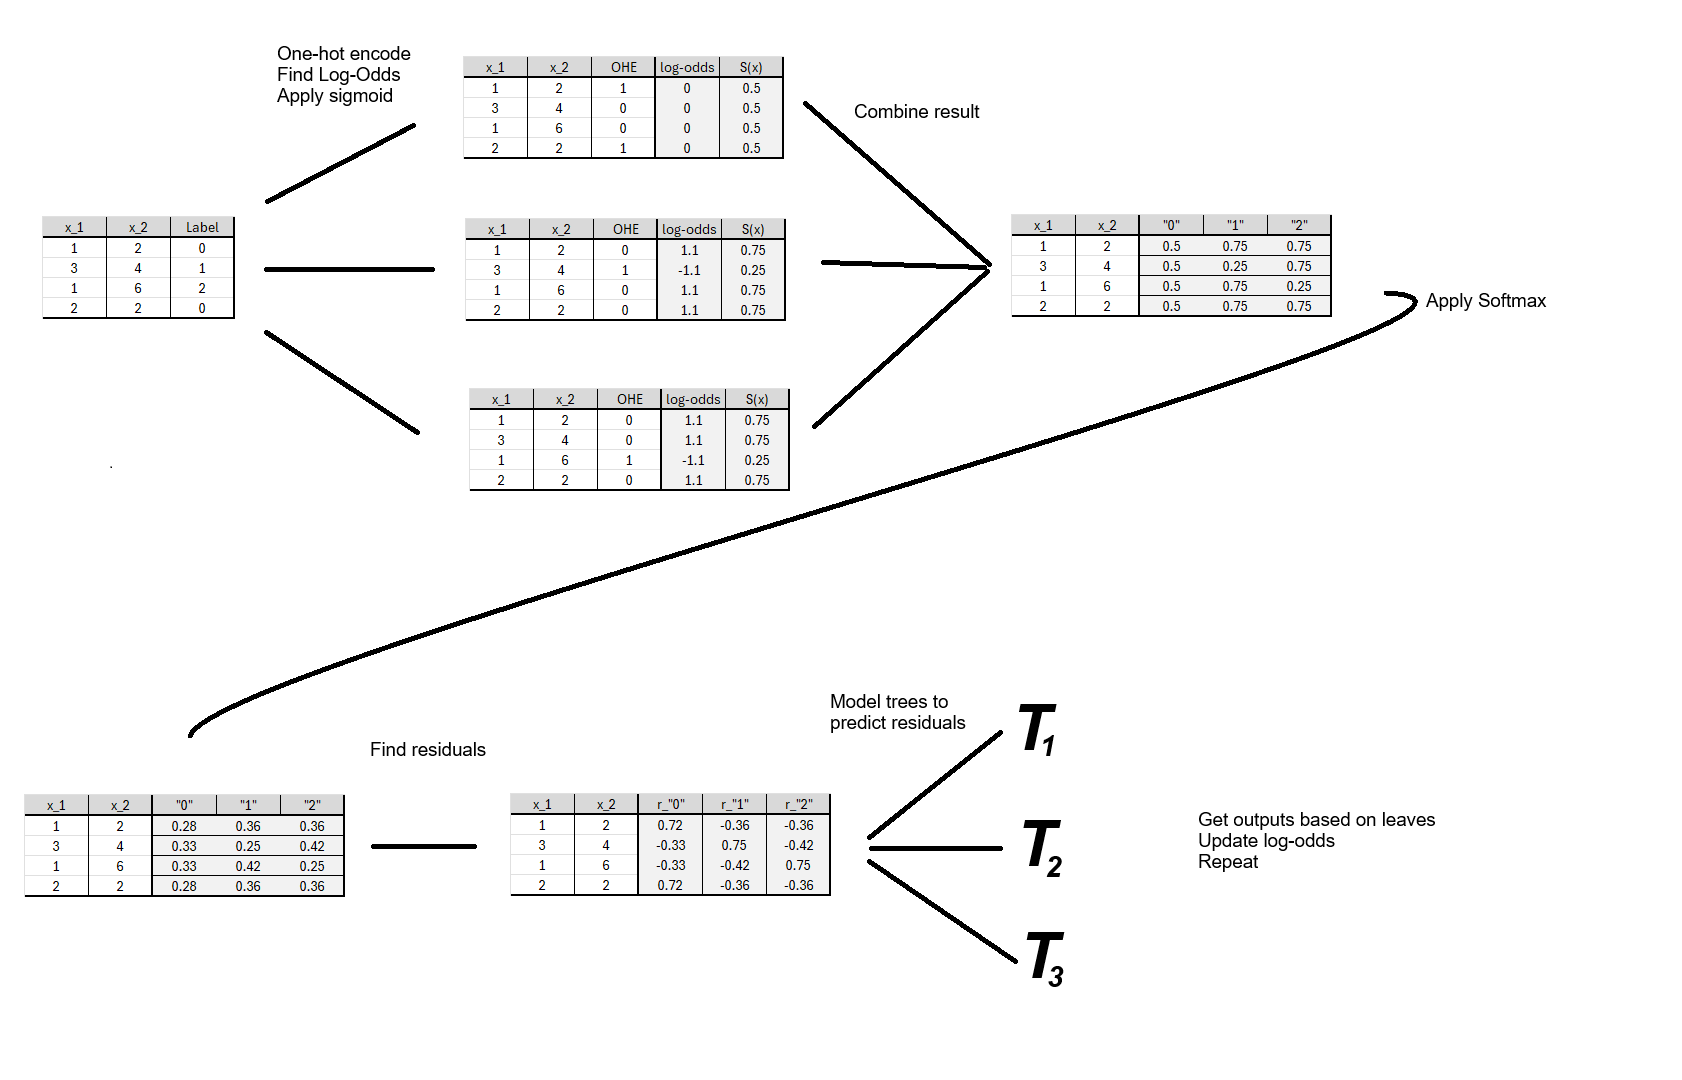

`GradientBoostingClassifier` supports multiclass classification. 

There are other variants of Gradient Boost Algorithms such as `HistGradientBoostingClassifier` (or regressor) which is faster algorithm and can handle missing values. There are also AdaBoost, LightGBM and many more. 

### XGBoost

One algorithm that gained a lot of popularity is XGBoost (Extreme Gradient Boost). This algorithm is quite powerful and can even outperform some neural networks. Main features of XGBoost:

1. Regularization. It natively uses L1 and L2 regularization
2. Supports Parallelization to speed up training.
3. Handles sparse data well
4. Has build-in crossvalidation
5. Handles missing values by separatigng them fromt he data sets. Then, when constructing trees and computing the best split, it considers information gain of placing missing data into left leaf and right leaf.
6. Deals with unbalanced datasets well by using weighting techniques.
7. Uses quantiles to check the best split instead of checking every posibility, which speeds up tree construction sacrifying getting best possible split. However, due to using weighting, the splits are quite good.



Let's apply XGBoost to our cancer dataset. I will use the same train and test sets. XGBoost uses its own format to store data called DMatrix. So, the first thing we need to do is to convert our datasets to DMatrix.

In [2]:
bcancer=datasets.load_breast_cancer()
X, y = bcancer.data, bcancer.target
data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)

In [3]:
param_dist  = {
              'objective':['binary:logistic'],
              'n_estimators': [30, 100, 200],
              'max_depth' : [2,3,4, 5],
              'learning_rate' :[0.01, 0.1, 1],
              'alpha':[5, 10, 20],    #L1 reg.  lambda is L2
             }

In [4]:
model=xgb.XGBClassifier()
cv = GridSearchCV(model, param_dist, cv=5)

cv.fit(X_train, y_train, sample_weight=sample_weights)
print("Tuned Parameters: {}".format(cv.best_params_))
print("Best score is {}".format(cv.best_score_))

Tuned Parameters: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'binary:logistic'}
Best score is 0.9516483516483516


In [5]:
params = {
            'objective':'binary:logistic',
            'max_depth': 3,
            'alpha': 5,
            'learning_rate': 0.1,
            'n_estimators':100
        }           
            
            
xgb_clf = xgb.XGBClassifier(**params, booster='gbtree')
xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(alpha=5, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [6]:
confusion_matrix(y_test,xgb_clf.predict(X_test))

array([[35,  1],
       [ 0, 78]], dtype=int64)

In [7]:
result=xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100, early_stopping_rounds=10, metrics="auc",as_pandas=True)
print(result)

C:\Users\Oleg\anaconda3\envs\Torch\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:09:05] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.984334       0.005086       0.946511      0.011383
1         0.990749       0.006896       0.965203      0.015331
2         0.994231       0.002934       0.973309      0.008415
3         0.994217       0.003245       0.974914      0.004808
4         0.994704       0.002641       0.974918      0.005799
..             ...            ...            ...           ...
61        0.999167       0.000598       0.987261      0.008129
62        0.999167       0.000598       0.987261      0.008129
63        0.999167       0.000598       0.987261      0.008129
64        0.999167       0.000598       0.987241      0.008156
65        0.999167       0.000598       0.987281      0.008101

[66 rows x 4 columns]


<Figure size 600x400 with 0 Axes>

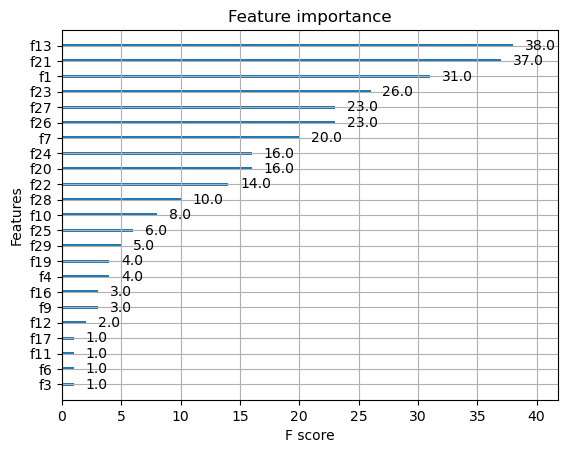

In [8]:
plt.figure(figsize=[6,4])
xgb.plot_importance(xgb_clf)
plt.show()

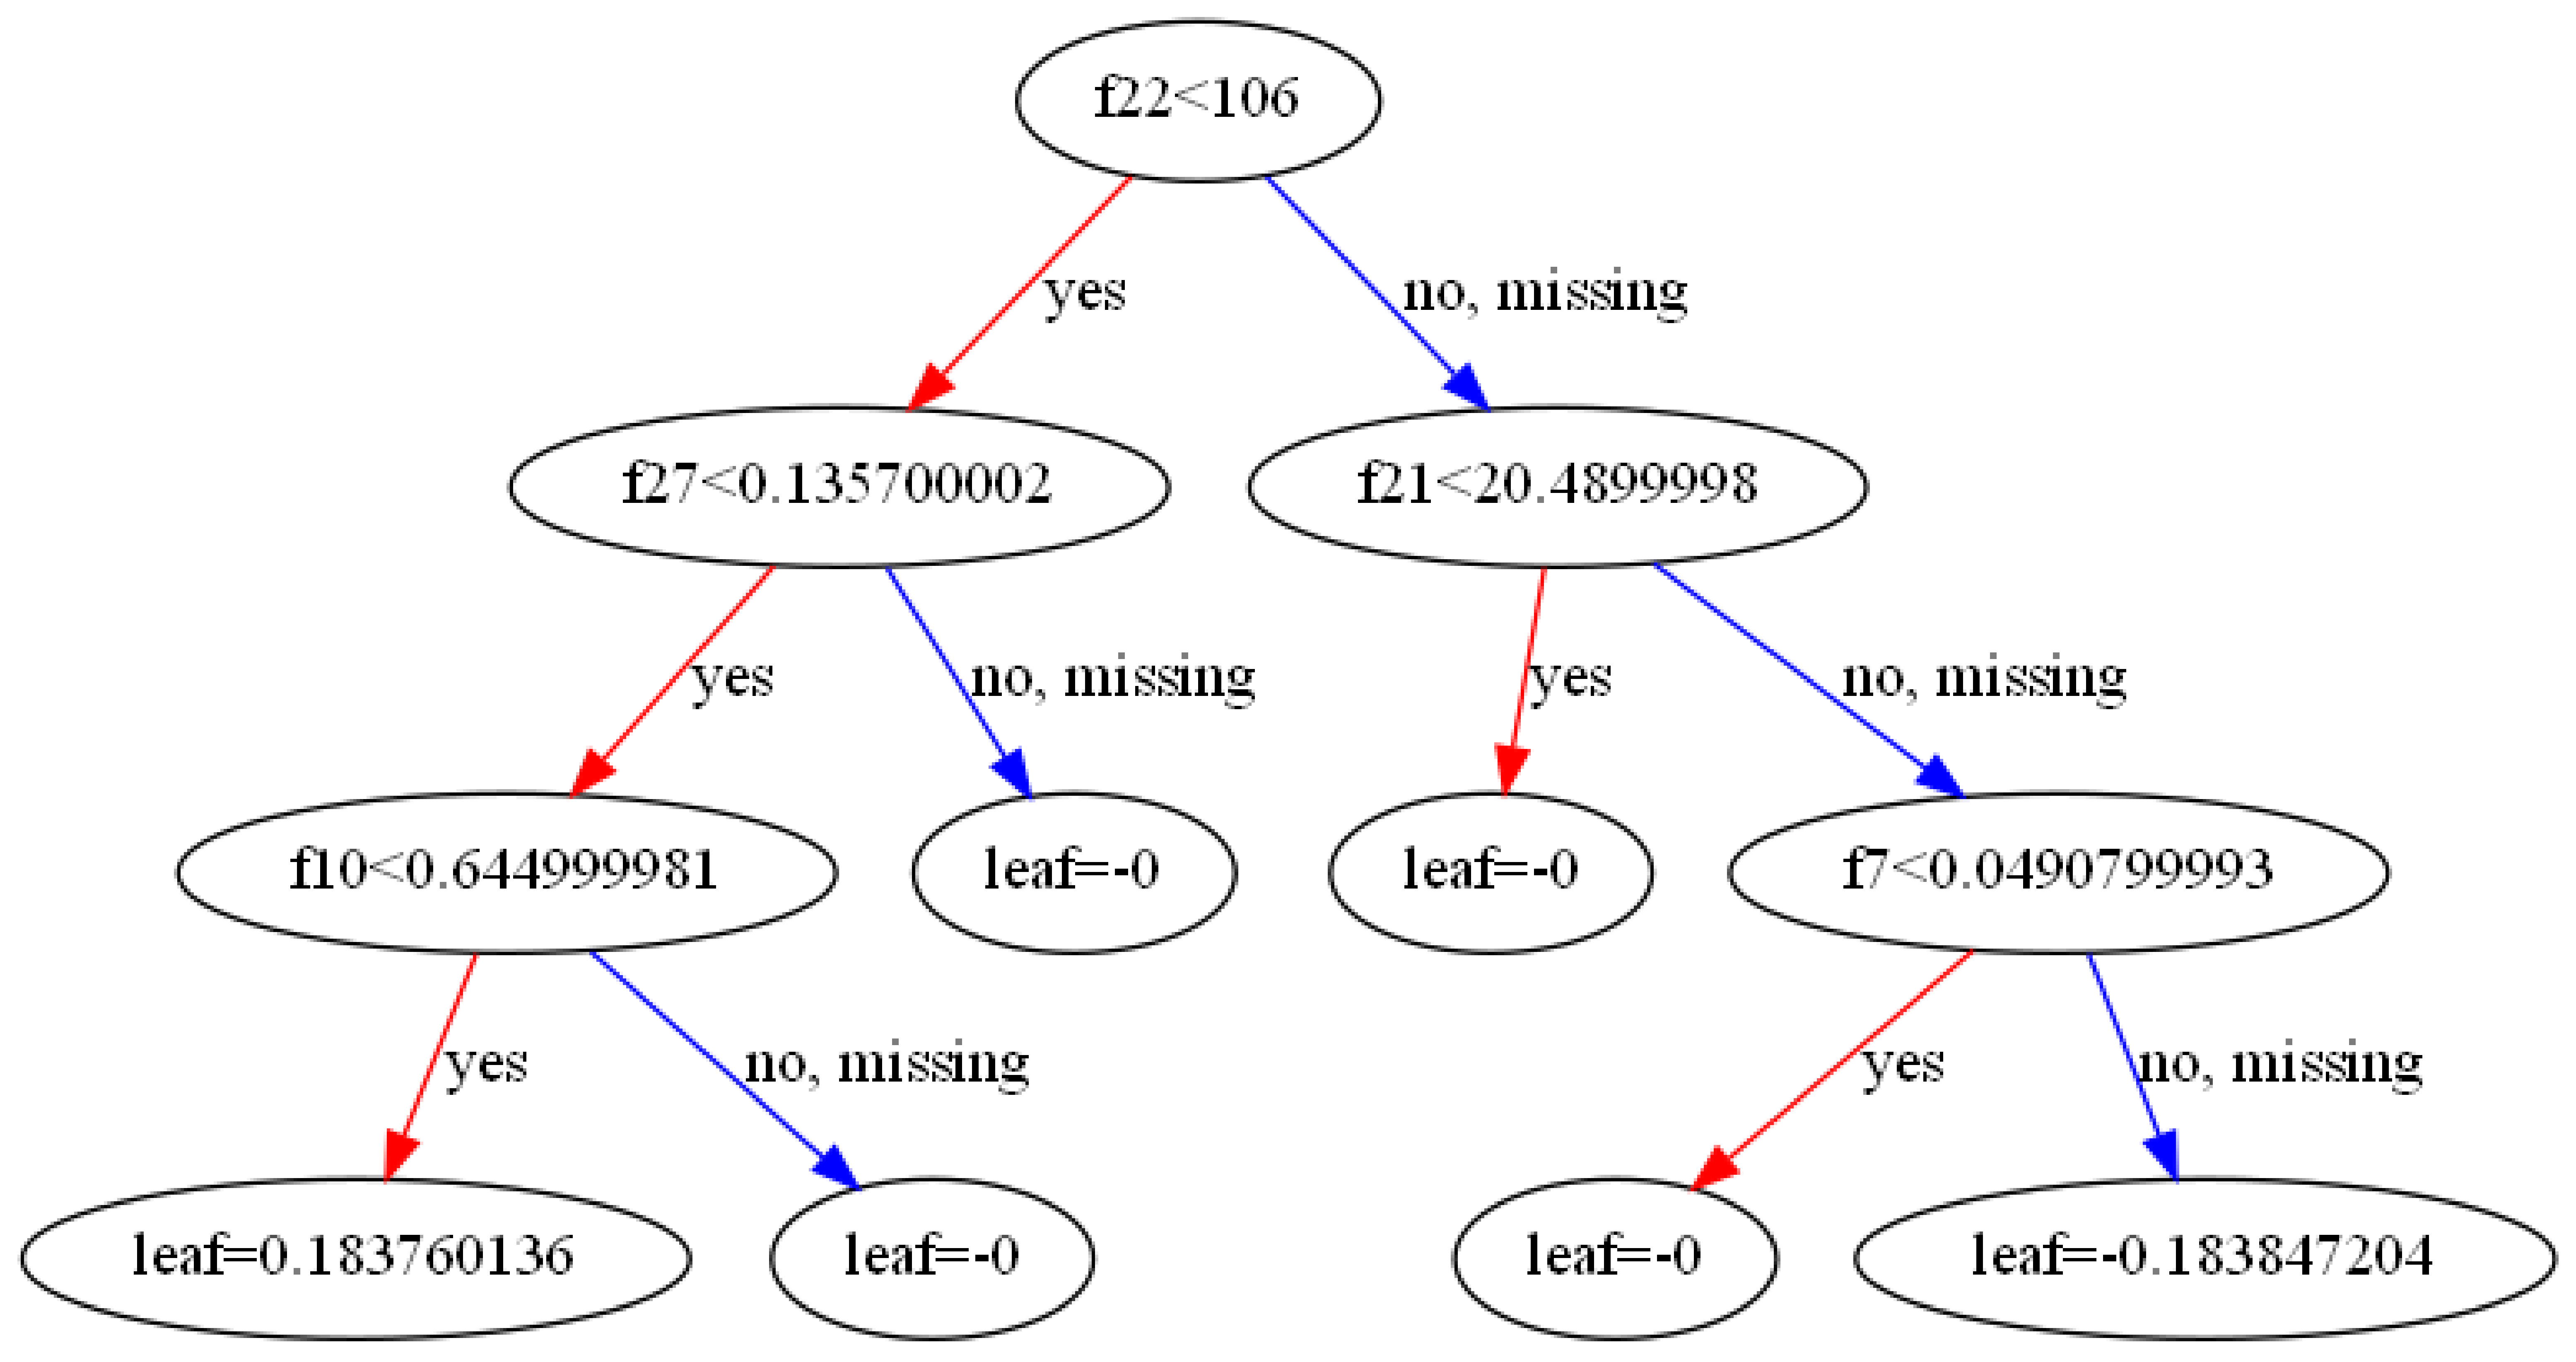

In [19]:
rcParams['figure.figsize'] = 80,50
xgb.plot_tree(xgb_clf, num_trees=0)
plt.show()

For multiclass classification, you would use a different objective (`multi:softmax`  or `multi:softprob`).

For regression, you can use XGBRegressor.

Other parameters worth knowing are `subsample` (ratio of how many samples to use on a single tree), `colsample_bytree` (ratio of features to use on each tree)